# Detecting temperature targets
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/target_temp_detection/tree/main)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/target_temp_detection/blob/main/_train_model.ipynb)

_(ignore the badges for now - they are for when I post on github)_
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh

## Python setup stuff

The following code is for setting up a local environment.
```
conda create --name env-noah python=3.9
conda activate env-noah
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn palettable progressbar2 tabulate icecream flake8 keras-tuner sklearn jupyterlab black isort jupyterlab_code_formatter
pip install -U scikit-learn
pip install silence-tensorflow tqdm
conda install -c conda-forge cmocean cartopy
conda install -c conda-forge xarray dask netCDF4 bottleneck
conda install -c conda-forge nc-time-axis
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
if IN_COLAB:
    !pip install xarray==0.20.2
    !pip install nc-time-axis

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0


## Define parameters

In [4]:
DATA_DIRECTORY = 'data/'
filenames = ('tas_Amon_historical_ssp370_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc',
             'tas_Amon_historical_ssp370_GISS-E2-1-G_r1-10_ncecat_ann_mean_2pt5degree.nc',
             'tas_Amon_historical_ssp370_IPSL-CM6A-LR_r1-10_ncecat_ann_mean_2pt5degree.nc',
             'tas_Amon_historical_ssp370_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc',
             'tas_Amon_historical_ssp370_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc',
            )
N_MODELS = len(filenames)
N_TRAIN, N_VAL, N_TEST = (7,3,0)

TARGET_TEMP = 1.5
BASELINE_YEARS = ('1850','1899')
START_YEAR = 1960
LAT_START = -90
REMOVE_MEAN = None # OPTIONS: None, 'weighted', 'raw'

## Define the target year and labels

For starters, we will define the target year as the year that the ensemble mean, global mean temperature crosses the ```TARGET_TEMP``` threshold.

In [21]:
def get_labels(da, plot=False):
    # compute the ensemble mean, global mean temperature
    # these computations should be based on the training set only
    da_ens = da.mean(axis=0)
    weights = np.cos(np.deg2rad(da_ens.lat))
    weights.name = "weights"
    temp_weighted = da_ens.weighted(weights)
    global_mean = temp_weighted.mean(("lon", "lat"))
    
    global_mean_ens = da.weighted(weights)
    global_mean_ens = global_mean_ens.mean(("lon","lat"))
    
    # compute the target year 
    baseline_mean = global_mean.sel(time=slice(BASELINE_YEARS[0],BASELINE_YEARS[1])).mean('time')
    iwarmer = np.where(global_mean.values > baseline_mean.values+TARGET_TEMP)[0]
    target_year = global_mean["time"].values[iwarmer[0]]


    # plot the calculation to make sure things make sense
    if plot == True:
        for ens in np.arange(0,global_mean_ens.shape[0]):
            global_mean_ens[ens,:].plot(linewidth=1.0,color="gray")
        global_mean.plot(linewidth=2,label='data',color="aqua")
        plt.axhline(y=baseline_mean, color='k', linestyle='-', label='baseline temp')
        plt.axhline(y=baseline_mean+TARGET_TEMP, color='tab:blue',linewidth=1., linestyle='--', label='target temp')
        plt.axvline(x=target_year,color='tab:blue',linewidth=1., linestyle='--', label='target year')
        global_mean_obs.plot(linewidth=2,label='data',color="tab:orange")        
        plt.xlabel('year')
        plt.ylabel('temp (K)')
        plt.title(f + '\ntargets [' + str(target_year.year) + ', ' + str(TARGET_TEMP) + 'C]',
                  fontsize = 8,
                 )
        # plt.legend()
        plt.show()
    
    # define the labels
    print('TARGET_YEAR = ' + str(target_year.year))
    labels = target_year.year - da['time.year'].values
    # print('labels = ' + str(labels))
    
    return labels, da['time.year'].values, target_year.year

def preprocess_data(da, MEMBERS):

    i_lat_start = np.where(da['lat']>=LAT_START)[0][0]
    if MEMBERS is None:
        new_data = da[:,i_lat_start:,:]
    else:
        new_data = da[MEMBERS,:,i_lat_start:,:]
    
    if REMOVE_MEAN == 'raw':
        new_data = new_data - new_data.mean(("lon","lat"))
    elif REMOVE_MEAN == 'weighted':
        weights = np.cos(np.deg2rad(new_data.lat))
        weights.name = "weights"
        new_data_weighted = new_data.weighted(weights)
        new_data = new_data - new_data_weighted.mean(("lon","lat"))
        
    return new_data

def make_data_split(da, data, f_labels, f_years, labels, years, MEMBERS):

    # only train on certain samples
    iyears = np.where(f_years >= START_YEAR)[0]
    f_years = f_years[iyears]
    f_labels = f_labels[iyears]        
    
    # process the data, i.e. subtract the mean, etc.
    new_data = preprocess_data(da, MEMBERS)    
    new_data = new_data[:,iyears,:,:]
    
    if data is None:
        data = new_data.values
        labels = np.tile(f_labels,(len(MEMBERS),1))        
        years = np.tile(f_years,(len(MEMBERS),1))
    else:
        data = np.concatenate((data,new_data.values),axis=0)        
        labels = np.concatenate((labels,np.tile(f_labels,(len(MEMBERS),1))),axis=0)        
        years = np.concatenate((years,np.tile(f_years,(len(MEMBERS),1))),axis=0)
    
    return data, labels, years

### Get observations

In [22]:
nc_filename_obs = DATA_DIRECTORY + 'Land_and_Ocean_LatLong1_185001_202112_ann_mean_2pt5degree.nc'
da_obs = xr.open_dataset(nc_filename_obs)['tas']
# da_obs = da_obs.fillna(281.81423285)
weights = np.cos(np.deg2rad(da_obs.lat))
weights.name = "weights"
temp_weighted = da_obs.weighted(weights)
global_mean_obs = temp_weighted.mean(("lon", "lat"), skipna=False)

data_obs = preprocess_data(da_obs, MEMBERS=None,) 
x_obs = data_obs.values.reshape((data_obs.shape[0],data_obs.shape[1]*data_obs.shape[2]))
print('np.shape(x_obs) = ' + str(np.shape(x_obs)))

np.shape(x_obs) = (172, 10368)


### Get CMIP data

[0 1 2 3 4 5 6] [7 8 9] []
tas_Amon_historical_ssp370_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc


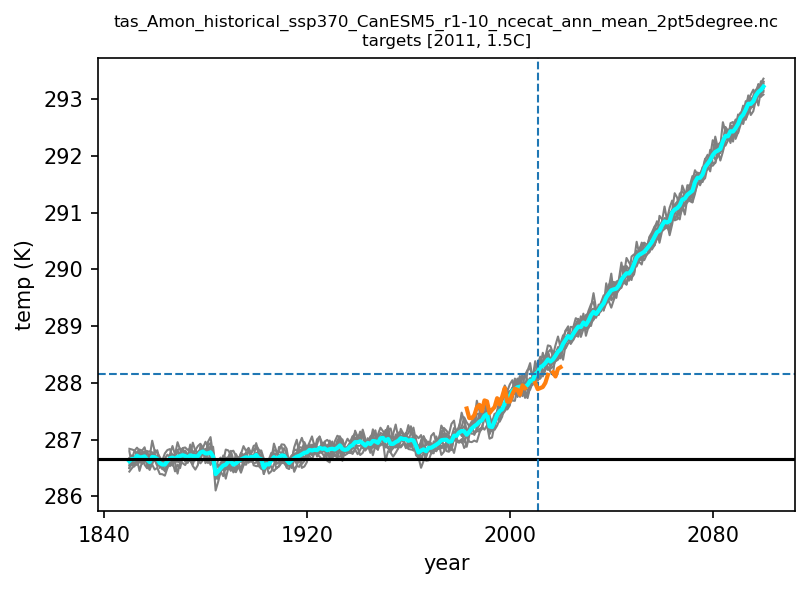

TARGET_YEAR = 2011
tas_Amon_historical_ssp370_GISS-E2-1-G_r1-10_ncecat_ann_mean_2pt5degree.nc


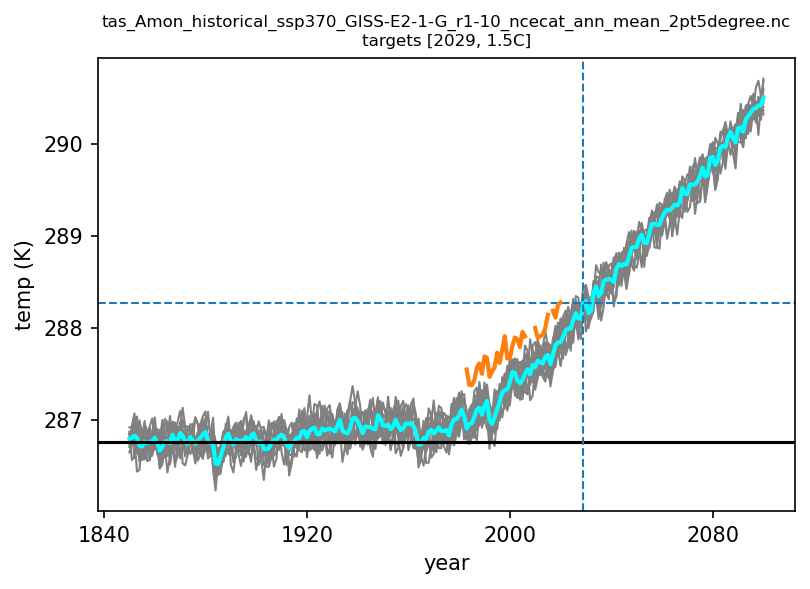

TARGET_YEAR = 2029
tas_Amon_historical_ssp370_IPSL-CM6A-LR_r1-10_ncecat_ann_mean_2pt5degree.nc


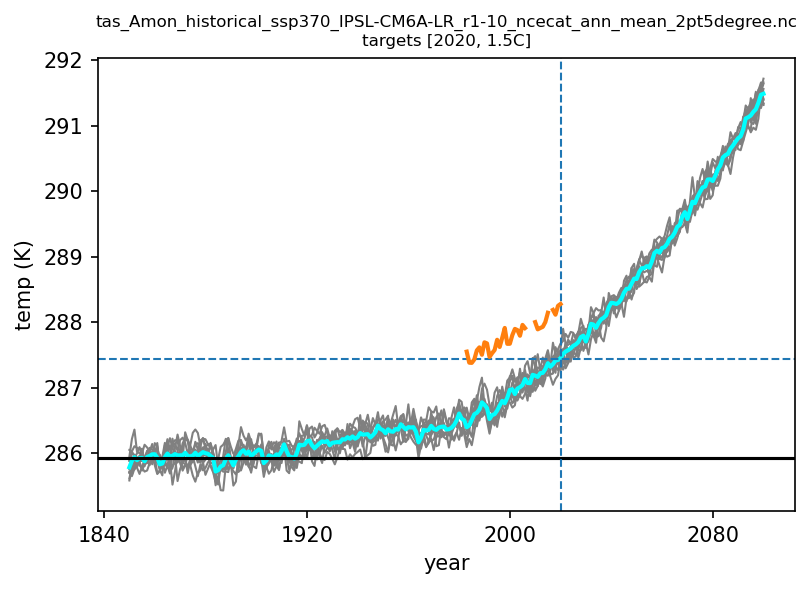

TARGET_YEAR = 2020
tas_Amon_historical_ssp370_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc


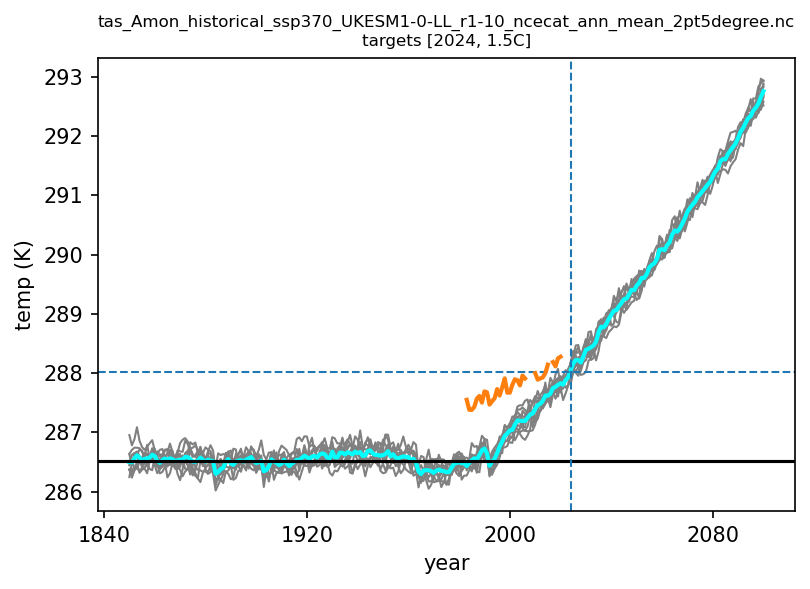

TARGET_YEAR = 2024
tas_Amon_historical_ssp370_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc


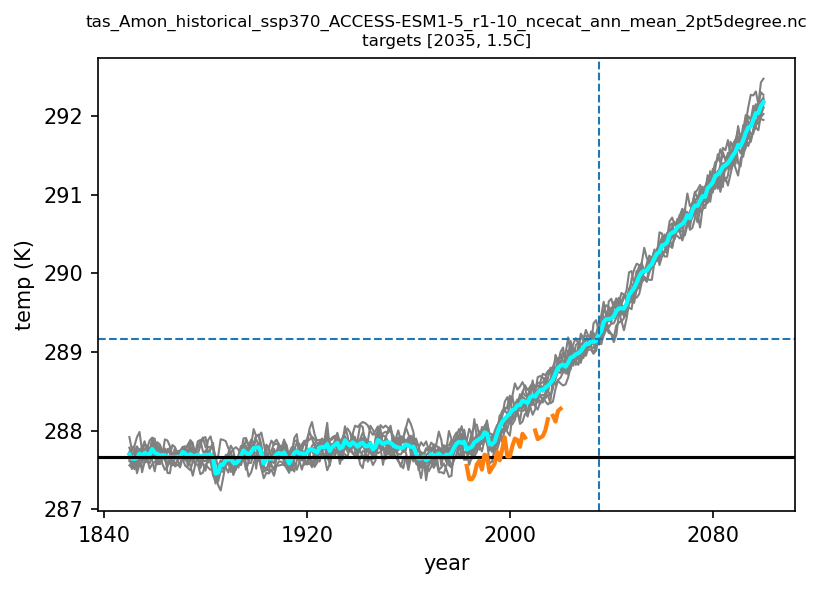

TARGET_YEAR = 2035
---------------------------
data_train.shape = (35, 141, 72, 144)
data_val.shape = (15, 141, 72, 144)
data_test.shape = (0, 141, 72, 144)


In [23]:
data_train, data_val, data_test = None, None, None
labels_train, labels_val, labels_test = None, None, None
years_train, years_val, years_test = None, None, None
target_years = []

TRAIN_MEMBERS = np.arange(0,N_TRAIN)
VAL_MEMBERS   = np.arange(N_TRAIN,N_TRAIN+N_VAL)
TEST_MEMBERS  = np.arange(N_TRAIN+N_VAL,N_TRAIN+N_VAL+N_TEST)
print(TRAIN_MEMBERS, VAL_MEMBERS, TEST_MEMBERS)

for f in filenames:
    print(f)
    da = xr.open_dataarray(DATA_DIRECTORY + f)
    f_labels, f_years, f_target_year = get_labels(da, plot=True)
        
    # create sets of train / validaton / test
    target_years = np.append(target_years,f_target_year)
    data_train, labels_train, years_train = make_data_split(da, 
                                                            data_train, 
                                                            f_labels, 
                                                            f_years, 
                                                            labels_train,
                                                            years_train,
                                                            TRAIN_MEMBERS)
    data_val, labels_val, years_val       = make_data_split(da, 
                                                            data_val, 
                                                            f_labels, 
                                                            f_years, 
                                                            labels_val,
                                                            years_val,
                                                            VAL_MEMBERS)
    data_test, labels_test, years_test    = make_data_split(da, 
                                                            data_test, 
                                                            f_labels, 
                                                            f_years, 
                                                            labels_test,
                                                            years_test,
                                                            TEST_MEMBERS)
    
print('---------------------------')        
YEARS_UNIQUE = np.unique(years_train)
print('data_train.shape = ' + str(np.shape(data_train)))
print('data_val.shape = ' + str(np.shape(data_val)))
print('data_test.shape = ' + str(np.shape(data_test)))

#### Reshape the data to get it ready for input into the ANN

In [8]:
x_train = data_train.reshape((data_train.shape[0]*data_train.shape[1],data_train.shape[2]*data_train.shape[3]))
x_val   = data_val.reshape((data_val.shape[0]*data_val.shape[1],data_val.shape[2]*data_val.shape[3]))
x_test  = data_test.reshape((data_test.shape[0]*data_test.shape[1],data_test.shape[2]*data_test.shape[3]))

y_train = labels_train.reshape((data_train.shape[0]*data_train.shape[1],))
y_val   = labels_val.reshape((data_val.shape[0]*data_val.shape[1],))
y_test  = labels_test.reshape((data_test.shape[0]*data_test.shape[1],))

y_yrs_train = years_train.reshape((data_train.shape[0]*data_train.shape[1],))
y_yrs_val   = years_val.reshape((data_val.shape[0]*data_val.shape[1],))
y_yrs_test  = years_test.reshape((data_test.shape[0]*data_test.shape[1],))

print(x_train.shape, y_train.shape, y_yrs_train.shape)
print(x_val.shape, y_val.shape, y_yrs_val.shape)
print(x_test.shape, y_test.shape, y_yrs_test.shape)

(4935, 10368) (4935,) (4935,)
(2115, 10368) (2115,) (2115,)
(0, 10368) (0,) (0,)


## Setup the network and associated callbacks

In [9]:
# define the model and its compile function
def compile_model(x_train):

    # First we start with an input layer
    inputs = Input(shape=x_train.shape[1:]) 

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(x_train)
    layers = normalizer(inputs)

    layers = Dropout(rate=DROP_RATE,
                     seed=SEED)(layers) 
    
    for hidden, activation, ridge in zip(HIDDENS, ACTIVATIONS, RIDGE):
        layers = Dense(hidden, activation=activation,
                       kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00, l2=ridge),
                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)


    # Output layer has a softmax function to convert output to class likelihood
    output_layer = Dense(1, activation='linear',
                      bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                      kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

    # Constructing the model
    model = Model(inputs, output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Using the Adam optimizer
    model.compile(optimizer=optimizer, loss=LOSS, metrics=['mse',])

    model.summary()
    
    return model

## Train the network

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10368)]           0         
                                                                 
 normalization (Normalizatio  (None, 10368)            20737     
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 10)                103690    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                             

2022-03-13 08:12:09.432887: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Restoring model weights from the end of the best epoch: 310.
Epoch 00340: early stopping


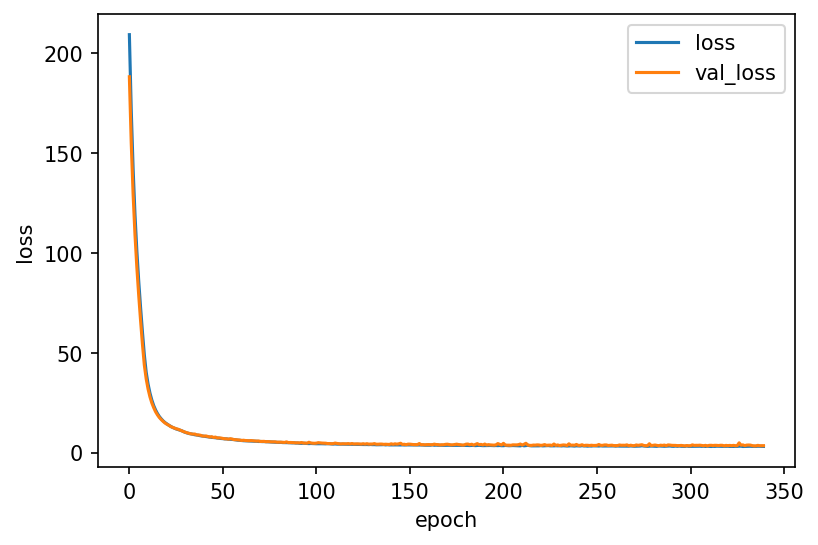

In [10]:
SEED = 8889
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
NUM_EPOCHS = 1_000
HIDDENS = [10,10]
RIDGE = [.75, 0.]
DROP_RATE = 0.0
ACTIVATIONS = ['relu'] * len(HIDDENS) 
LOSS = 'mae'
PATIENCE = 30
VERBOSITY = 0
#----------------------------------------

tf.keras.backend.clear_session()            
tf.random.set_seed(SEED)
np.random.seed(SEED)

# define early stopping callback
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=PATIENCE,
                                                   verbose=1,
                                                   mode='auto',
                                                   restore_best_weights=True)


model = compile_model(x_train)
history = model.fit(x_train, y_train, 
                    epochs=NUM_EPOCHS, 
                    verbose=VERBOSITY,
                    batch_size = BATCH_SIZE, 
                    shuffle=True,
                    validation_data=[x_val, y_val],
                    callbacks=[EARLY_STOPPING],
                   )
#----------------------------------------
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

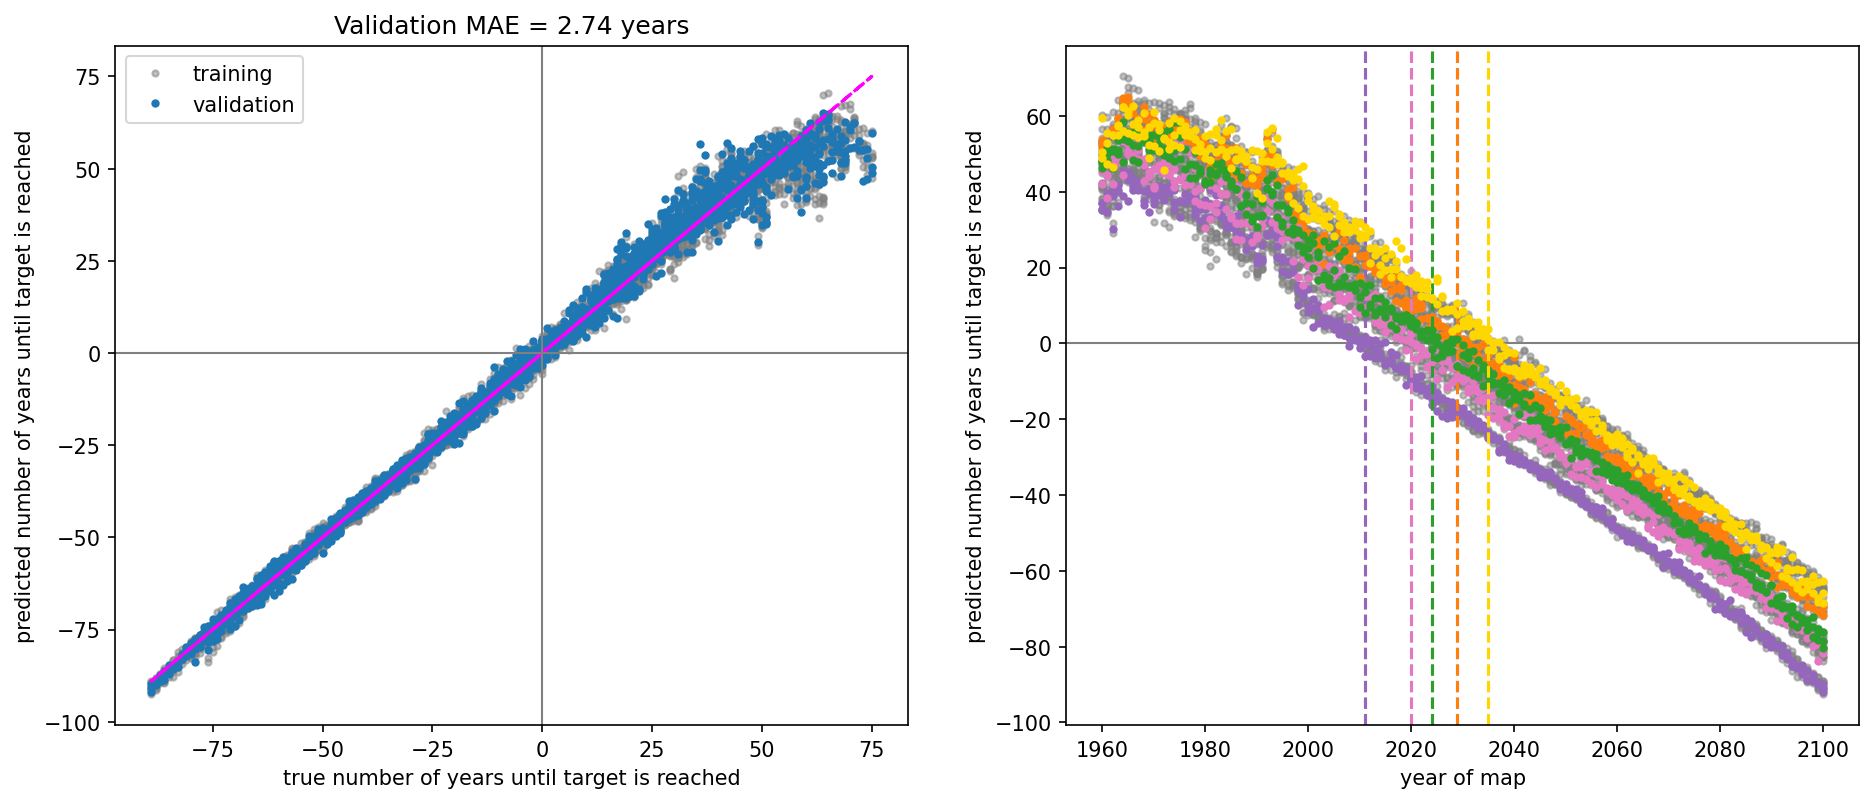

In [11]:
predict_train = model.predict(x_train)
predict_val = model.predict(x_val)
mae = np.mean(np.abs(predict_val[:,0]-y_val[:]))

clr = ('tab:purple','tab:orange', 'tab:pink', 'tab:green', 'gold', 'violet','cornflowerblue','darkorange')
#--------------------------------
plt.subplots(1,2,figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(y_train, predict_train,'.',color='gray',alpha=.5, label='training')
plt.plot(y_val, predict_val,'.', label='validation')
plt.plot(y_val,y_val,'--',color='fuchsia')
plt.axvline(x=0,color='gray',linewidth=1)
plt.axhline(y=0,color='gray',linewidth=1)
plt.title('Validation MAE = ' + str(mae.round(2)) + ' years')
plt.xlabel('true number of years until target is reached')
plt.ylabel('predicted number of years until target is reached')
plt.legend()



plt.subplot(1,2,2)
plt.plot(y_yrs_train, predict_train,'.',color='gray',alpha=.5, label='training')
plt.xlabel('year of map')
plt.ylabel('predicted number of years until target is reached')
plt.axhline(y=0, color='gray', linewidth=1)

predict_val_mat = predict_val.reshape(N_MODELS,N_VAL,len(YEARS_UNIQUE))
for i in np.arange(0,predict_val_mat.shape[0]):
    plt.plot(YEARS_UNIQUE, predict_val_mat[i,:,:].swapaxes(1,0),'.', label='validation', color=clr[i])
    plt.axvline(x=target_years[i],linestyle='--',color=clr[i])
if IN_COLAB==False:
    pass
    # plt.savefig('figures/initial_result_seed' + str(SEED) + '.png', dpi=savefig_dpi)
plt.show()

## Explainability via Input * Gradient and Integrated Gradients
We will use two attribution explainaiblity methods called Input * Gradient and Integrated Gradients to make heatmaps of regions of the input that act as explanations for the network's prediction.

* https://keras.io/examples/vision/integrated_gradients/
* https://distill.pub/2020/attribution-baselines/

In [12]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def random_baseline_integrated_gradients(inputs, num_steps=50, num_runs=5, top_pred_idx=None):
    """Generates a number of random baseline images.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.      

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.zeros(np.shape(inputs)[1:])
        for i in np.arange(0,np.shape(random_baseline)[0]):
            j = np.random.choice(np.arange(0,np.shape(inputs)[0]))
            baseline[i] = inputs[j,i]

        igrads = get_integrated_gradients(
            inputs=inputs,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)



In [13]:
#=========================================
# Define the samples you want to explain
rng = np.random.default_rng(45)
isubsample = rng.choice(np.arange(0,x_val.shape[0]),
                        size = 500,
                        replace = False,
                       )

inputs = np.copy(x_val[isubsample,:])
targets = np.copy(y_val[isubsample])
yrs = np.copy(y_yrs_val[isubsample])
preds = model.predict(inputs)
#=========================================

In [14]:
#---------------------------------------
# Gradient x Input
#---------------------------------------
# compute the multiplication of gradient * inputs
# and reshape into a map of latitude x longitude
grads = get_gradients(inputs).numpy()
grad_x_input = grads * inputs
grad_x_input = grad_x_input.reshape((len(targets),data_train.shape[2],data_train.shape[3]))
print(np.shape(grad_x_input))

(500, 72, 144)


In [15]:
#---------------------------------------
# Integrated Gradients
#---------------------------------------
BASELINE = 'zeros' #'zeros'#1850

# Alternative baselines
if(BASELINE=='zeros'):
    baseline_mean = np.mean(x_train,axis=0)*0.    
elif(BASELINE=='mean'):
    baseline_mean = np.mean(x_train,axis=0)  
else:
    baseline_mean = np.mean(data_train,axis=0)
    isample = np.where(years_train[0,:]==BASELINE)[0]
    baseline_mean = np.mean(baseline_mean[isample,:,:],axis=0)
    baseline_mean = baseline_mean.reshape((baseline_mean.shape[0]*baseline_mean.shape[1]))

print('shape(baseline_mean) = ' + str(np.shape(baseline_mean)))
print('model.predict(baseline_mean) = ' + str(model.predict(baseline_mean[np.newaxis,:])))

igrad = get_integrated_gradients(inputs, baseline=baseline_mean)
integrated_gradients = igrad.numpy().reshape((len(targets),data_train.shape[2],data_train.shape[3]))
print(np.shape(integrated_gradients))

shape(baseline_mean) = (10368,)
model.predict(baseline_mean) = [[7872.91]]
(500, 72, 144)


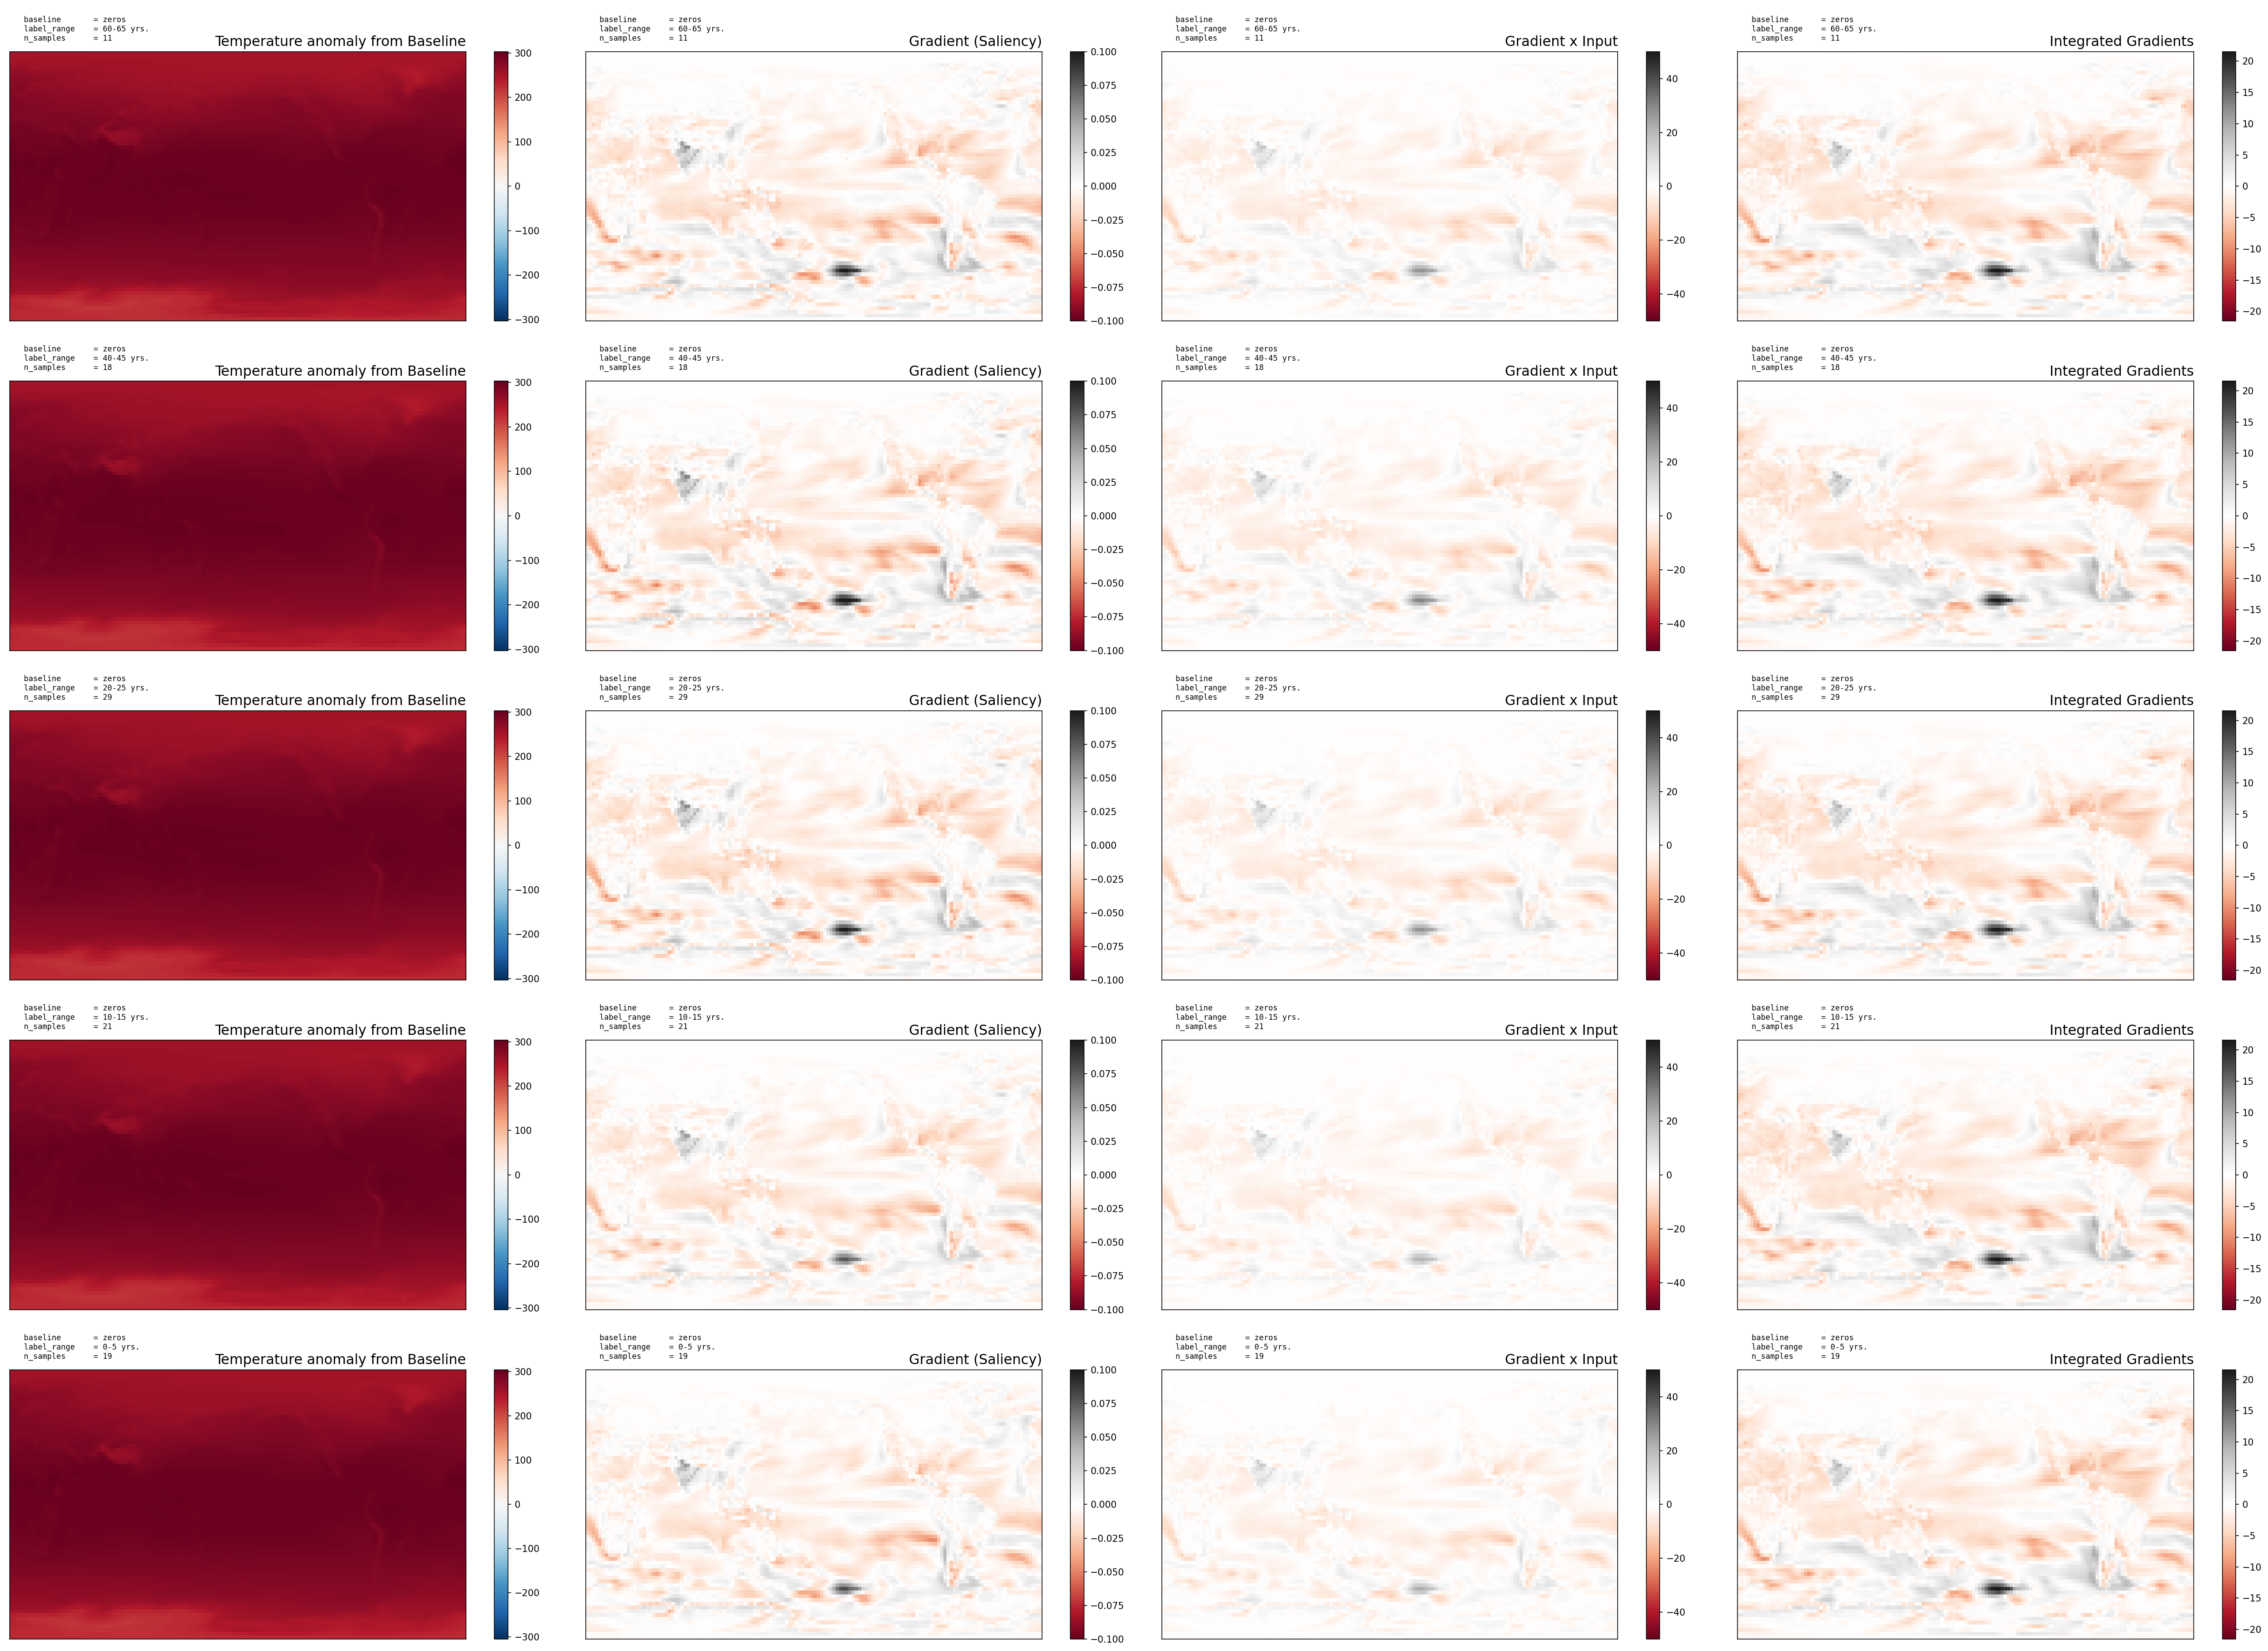

In [16]:
def plot_map(x, clim=None, title=None, text=None, cmap='RdGy'):
    if clim is None:
        plt.pcolor(x,
                   cmap=cmap,
                   norm=mpl.colors.CenteredNorm(),        
                  )
    else:
        plt.pcolor(x,
                   cmap=cmap,
                  )
    plt.clim(clim)
    plt.colorbar()
    plt.title(title,fontsize=15,loc='right')    
    plt.yticks([])
    plt.xticks([])
    
    plt.text(0.01, 1.0, text, fontfamily='monospace', fontsize='small', va='bottom',transform=plt.gca().transAxes)

# plot the resulting heatmaps for a subset of samples
# based on their label
plot_list = (60, 40, 20, 10, 0)
NCOL = 4
plt.subplots(len(plot_list),NCOL,figsize=(35,5*len(plot_list)))

for irow,min_range in enumerate(plot_list):
        
    max_range = min_range + 5
    isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
    igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
    grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)
    grad_mean = np.mean(grads[isamples,:],axis=0).reshape((data_train.shape[2],data_train.shape[3]))
    x_inputs_mean = np.mean(inputs[isamples,:],axis=0).reshape((data_train.shape[2],data_train.shape[3]))
    x_inputs_mean = x_inputs_mean - baseline_mean.reshape((data_train.shape[2],data_train.shape[3]))
    #------------------------------------------------------------------
    
    text = (
            "\n"
            + f"  baseline       = {BASELINE}\n"           
            + f"  label_range    = {min_range}-{max_range} yrs.\n"                    
            + f"  n_samples      = {len(isamples)}\n"
    )    
    #------------------------------------------------------------------    
    
    # plot average input map
    plt.subplot(len(plot_list),NCOL,irow*NCOL+1)
    plot_map(x_inputs_mean, 
             text=text,
             # clim=(-10,10),
             # clim=(250,310),
             cmap='RdBu_r',
             title = 'Temperature anomaly from Baseline',
            )
    #------------------------------------------------------------------
    # plot explainability of gradient (saliency)
    plt.subplot(len(plot_list),NCOL,irow*NCOL+2)
    plot_map(grad_mean, 
             text=text,             
             clim=(-0.1, .1), 
             title = 'Gradient (Saliency)',
            )
    
    #------------------------------------------------------------------
    # plot explainability of input x gradient
    plt.subplot(len(plot_list),NCOL,irow*NCOL+3)
    plot_map(grad_x_input_mean, 
             text=text,
             clim=(-50,50),
             title = 'Gradient x Input',
            )

    #------------------------------------------------------------------
    # plot explainability of integrated gradients
    plt.subplot(len(plot_list),NCOL,irow*NCOL+4)
    plot_map(igrad_mean, 
             text=text,             
             # clim=(-.25,.25), 
             title = 'Integrated Gradients',
            )

plt.tight_layout()   
if IN_COLAB==False:
    pass
    # plt.savefig('figures/xai_grid_' + str(min_range) +'-' + str(max_range) + '_baseline_' + str(BASELINE) + '.png', dpi=savefig_dpi)
plt.show()



## Predict observations

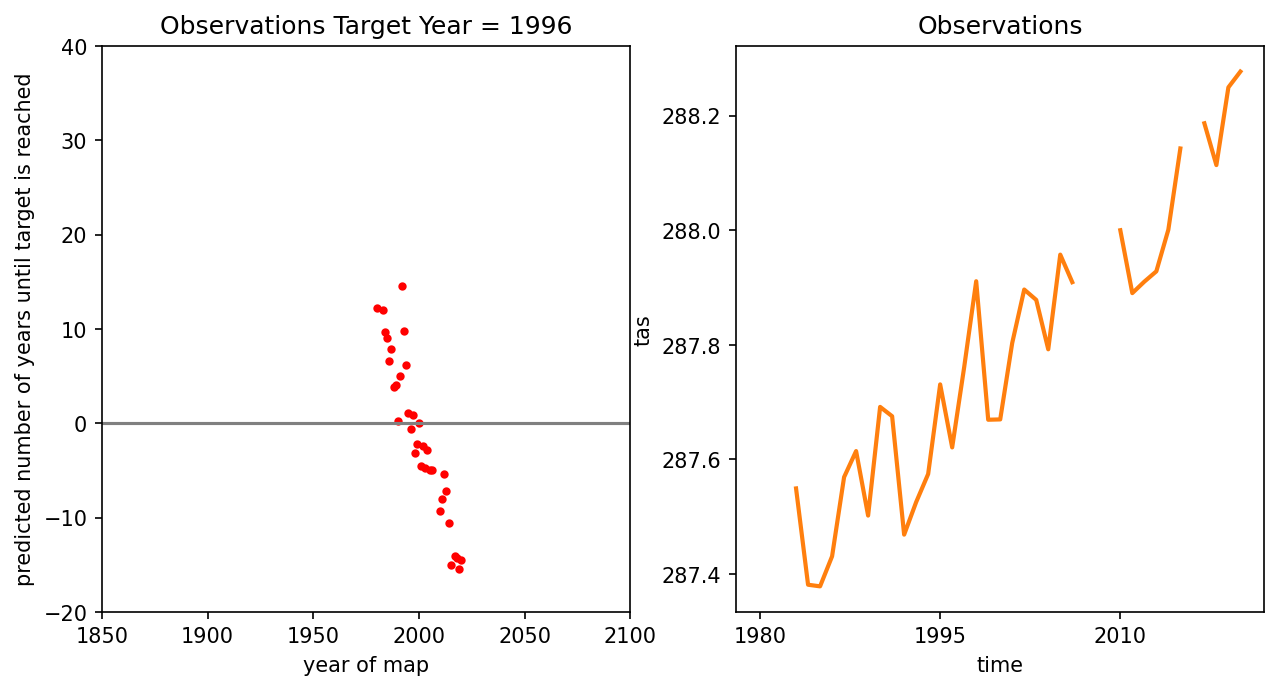

In [17]:
y_predict_obs = model.predict(x_obs)

#--------------------------------
i_year = np.where(y_predict_obs < 0)[0]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(da_obs['time.year'], y_predict_obs, '.r')
plt.xlabel('year of map')
plt.ylabel('predicted number of years until target is reached')
plt.title('Observations Target Year = ' + str(da_obs['time.year'].values[i_year[0]]))
plt.xlim(1850,2100)
plt.ylim(-20,40)
plt.axhline(y=0,color='gray')

#--------------------------------
plt.subplot(1,2,2)
global_mean_obs.plot(linewidth=2,label='data',color="tab:orange")
plt.title('Observations')
plt.show()
